### Imports

In [52]:
%load_ext autoreload
%autoreload 2
from convnet import ConvDipNet
from timeDistributed import TimeDistributed
from torchinfo import summary
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torch
import sys; sys.path.insert(0, '../')
from esinet.forward import create_forward_model, get_info
from esinet import Simulation
from copy import deepcopy
from CNN_LSTM.util import *
from dipoleDataset import DipoleDataset

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Model Definition

In [66]:
# define hyperparameters
in_channels = 1
im_shape = (9,9)
n_filters = 8
kernel_size = (3,3)

# create single input ConvDipNet 
convnet: nn.Module  = ConvDipNet(in_channels, im_shape, n_filters, kernel_size)

# create TimeDistributed ConvDipNet to process all samples of timeseries at once
time_distributed_convnet: nn.Module = TimeDistributed(convnet, batch_first=True) # change batch_first to False for now for evaluation, will change back later

# print model summary
summary(time_distributed_convnet, input_size=(32, 100, 1, im_shape[0], im_shape[1])) # (batch_size, n_timesteps, in_channels, height, width)

Layer (type:depth-idx)                   Output Shape              Param #
TimeDistributed                          [32, 100, 5124]           --
├─ConvDipNet: 1-1                        [3200, 5124]              --
│    └─Conv2d: 2-1                       [3200, 8, 9, 9]           80
│    └─Linear: 2-2                       [3200, 512]               332,288
│    └─Linear: 2-3                       [3200, 5124]              2,628,612
Total params: 2,960,980
Trainable params: 2,960,980
Non-trainable params: 0
Total mult-adds (Units.GIGABYTES): 9.50
Input size (MB): 1.04
Forward/backward pass size (MB): 160.87
Params size (MB): 11.84
Estimated Total Size (MB): 173.75

### Create forward model for simulations

In [54]:
# create forward model
fs = 100
info = get_info(sfreq=fs)
fwd = create_forward_model(sampling='ico4', info=info)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 14 concurrent workers.
0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.
0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.
0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.
0.00s

0 files missing from root.txt in /Users/zacariabalkhy/mne_data/MNE-sample-data/subjects
0 files missing from bem.txt in /Users/zacariabalkhy/mne_data/MNE-sample-data/subjects/fsaverage
Using surface: /Users/zacariabalkhy/mne_data/MNE-sample-data/subjects/fsaverage/bem/inner_skull.surf
Using surface: /Users/zacariabalkhy/mne_data/MNE-sample-data/subjects/fsaverage/bem/outer_skull.surf
Using surface: /Users/zacariabalkhy/mne_data/MNE-sample-data/subjects/fsaverage/bem/outer_skin.surf


/Users/zacariabalkhy/UCDAVIS_COURSES/MAE298/final_project/esinet_MAE298/venv/lib/python3.12/site-packages/mne/viz/utils.py:167: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


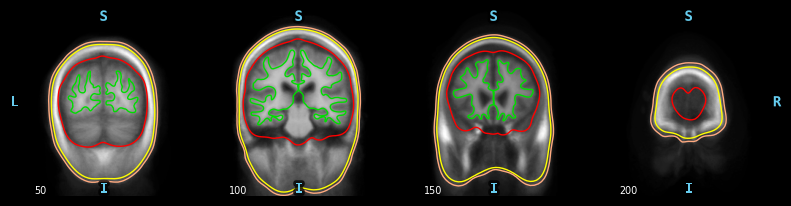

In [55]:
# plot BEM
import mne
import os
fs_dir = mne.datasets.fetch_fsaverage(verbose=True)
subjects_dir = os.path.dirname(fs_dir)
plot_bem_kwargs = dict(
    subject='fsaverage',
    subjects_dir=subjects_dir,
    brain_surfaces="white",
    orientation="coronal",
    slices=[50, 100, 150, 200],
)
mne.viz.plot_bem(**plot_bem_kwargs)


### Run simulations to create train/test/validation data

In [56]:
# define simulation settings
n_samples = 100
settings = dict(number_of_sources=(1, 5), extents=(21, 58)) # settings from paper

# create simulation data using forward model
sim = Simulation(fwd, info, settings=settings).simulate(n_samples=n_samples)


Simulating data based on sparse patches.


100%|██████████| 100/100 [00:04<00:00, 22.08it/s]


In [57]:
# extract eeg and source data as numpy arrays
eeg_data = np.array([sim.eeg_data[i].get_data().squeeze() for i in range(len(sim.eeg_data))]) 
source_data = np.array([sim.source_data[i].data for i in range(len(sim.source_data))])

/var/folders/4j/tlx3f80d0rz_mzn5sy7p20ww0000gn/T/ipykernel_2548/2796843691.py:2: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  eeg_data = np.array([sim.eeg_data[i].get_data().squeeze() for i in range(len(sim.eeg_data))])
/var/folders/4j/tlx3f80d0rz_mzn5sy7p20ww0000gn/T/ipykernel_2548/2796843691.py:2: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  eeg_data = np.array([sim.eeg_data[i].get_data().squeeze() for i in range(len(sim.eeg_data))])
/var/folders/4j/tlx3f80d0rz_mzn5sy7p20ww0000gn/T/ipykernel_2548/2796843691.py:2: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  eeg_data = np.array([sim.eeg_data[i].get_data().squeeze() for i in range(len(sim.eeg_data))])
/var/folders/4j/tlx3f80d0rz_mzn5sy7p20ww0000gn/T/ipykernel

### Rescale and interpolate data

In [58]:
x_scaled = scale_eeg(eeg_data)
y_scaled  = scale_source(source_data)
x_scaled = [np.swapaxes(x,0,1) for x in eeg_data]
y_scaled = [np.swapaxes(y,0,1) for y in source_data]

print(len(x_scaled), x_scaled[0].shape)  # should be (n_samples, n_timesteps, n_channels)
print(len(y_scaled), y_scaled[0].shape)  # should be (n_samples, n_timesteps, n_dipoles)

100 (100, 61)
100 (100, 5124)


In [59]:
info = sim.eeg_data[0].info
x_scaled = interpolate_eeg(x_scaled, im_shape, info)

print(len(x_scaled), x_scaled[0].shape)  # should be (n_samples, n_timesteps, n_channels, im_height, im_width)

100 (100, 1, 9, 9)


### Split and batch data with a Dataloader

In [60]:
dataset = DipoleDataset(x_scaled, y_scaled, im_shape=im_shape)
test_size = 0.15
val_size = 0.15

test_amount, val_amount = int(dataset.__len__() * test_size), int(dataset.__len__() * val_size)

# this function will automatically randomly split your dataset but you could also implement the split yourself
train_set, val_set, test_set = torch.utils.data.random_split(dataset, [
            (dataset.__len__() - (test_amount + val_amount)), 
            test_amount, 
            val_amount
])

In [61]:
B = 1  # batch size
train_dataloader = torch.utils.data.DataLoader(
            train_set,
            batch_size=B,
            shuffle=True,
)
val_dataloader = torch.utils.data.DataLoader(
            val_set,
            batch_size=B,
            shuffle=True,
)
test_dataloader = torch.utils.data.DataLoader(
            test_set,
            batch_size=B,
            shuffle=True,
)

### Train Loop

In [ ]:
criterion = nn.CrossEntropyLoss()
lr = 0.001
betas=(0.9, 0.999)
eps = 1e-8
optimizer = optim.Adam(time_distributed_convnet.parameters(), lr=lr, 
                       betas=betas, eps=eps)
for epoch in range(10):  # loop over the dataset multiple times
    running_loss = 0.0
    i = 0
    for sample, target in train_dataloader:

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = time_distributed_convnet(sample)
        loss = criterion(outputs, target)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        #if i % 2000 == 1999:    # print every 2000 mini-batches
        print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss:.8e}')
        running_loss = 0.0
        i += 1

print('Finished Training')

[1,     1] loss: 5.75766741e-08
[1,     2] loss: 4.60100793e-08
[1,     3] loss: -1.52846974e-06
[1,     4] loss: -3.35660360e-07
[1,     5] loss: 5.68554697e-07
[1,     6] loss: -1.98236751e-08
[1,     7] loss: -6.92035158e-08
[1,     8] loss: 4.33583232e-08
[1,     9] loss: 2.58682586e-08
[1,    10] loss: -1.25008679e-08
[1,    11] loss: -2.56794621e-08
[1,    12] loss: -7.34823452e-11
[1,    13] loss: -2.77998726e-08
[1,    14] loss: 2.62476021e-07
[1,    15] loss: -4.93857669e-07
[1,    16] loss: -3.84194607e-07
[1,    17] loss: 1.50121807e-07
[1,    18] loss: -7.09136661e-09
[1,    19] loss: -2.34709873e-07
[1,    20] loss: 6.22793479e-08
[1,    21] loss: 2.30277788e-08
[1,    22] loss: -4.23925641e-08
[1,    23] loss: 1.31957506e-07
[1,    24] loss: -1.19690455e-07
[1,    25] loss: -5.35567040e-08
[1,    26] loss: -3.21975818e-07
[1,    27] loss: 6.96466373e-07
[1,    28] loss: -5.95326924e-07
[1,    29] loss: 1.32806235e-07
[1,    30] loss: 5.19345576e-07
[1,    31] loss: -9.756